In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, log
from matplotlib.colors import ListedColormap
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     RandomizedSearchCV, GridSearchCV, cross_val_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import pickle

import warnings
warnings.filterwarnings('ignore')

# set default style
from matplotlib import rcParams
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(10,4)})
rcParams['figure.figsize'] = 10,4

# 1. Model Evaluation and Selection

## 1.1 Model Training

In [2]:
# Importing the dataset
dataset = pd.read_csv('https://raw.githubusercontent.com/shivang98/Social-Network-ads-Boost/master/Social_Network_Ads.csv')
X = dataset.iloc[:, [2, 3]]
y = dataset.iloc[:, 4]

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
classifier = SVC(kernel='rbf', random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Evaluation trough the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[64  4]
 [ 3 29]]


## 1.2 StratifiedKFold
https://machinelearningmastery.com/implement-resampling-methods-scratch-python/

StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

In [ ]:
skf = StratifiedKFold(n_splits=3)
split = skf.split(X_train, y_train)
print("Original Sample Size: ", len(X_train))

for train, test in split:
  print("Training Set", len(train))
  print("Testing Set", len(test))
  break

Original Sample Size:  300
Training Set 200
Testing Set 100


## 1.3 Cross Validation

Training and testing are not enough to evaluate the performance, different test set has different variance

k-fold cross validation, k iteration to combine accuracy

In [ ]:
# Applying k-Fold Cross Validation to generat 10 accuracies result
# use njobs-1 to use all cpu when using large dataset, to run faster
classifier = SVC(kernel='rbf', random_state=99)
accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10)

In [ ]:
# find the mean of 10 accuracies
print(accuracies.mean())
print(accuracies.std())

0.9033333333333333
0.0744610263456289


## 1.4 Grid Search

To find the best model and the best parameters. Normally, it is coded after classification model

Acuracy is the most common performance metric, it can be recall/precision 

https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

https://scikit-learn.org/stable/modules/grid_search.html#grid-search

In [ ]:
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 
               'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=parameters,
                           scoring='accuracy',
                           cv=10,
                           n_jobs=-1)

grid_search = grid_search.fit(X_train, y_train)

In [ ]:
# the result of grid search and best parameters
print(grid_search.best_score_)
print( grid_search.best_params_)

0.9066666666666666
{'C': 1, 'gamma': 0.7, 'kernel': 'rbf'}


In [ ]:
grid_predictions = grid_search.predict(X_test)
print(grid_predictions)

[0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1
 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1]


In [ ]:
accuracies = cross_val_score(estimator=grid_search, X=X_train, y=y_train, cv=10)
print(accuracies.mean())
print(accuracies.std())

0.8966666666666667
0.0604611904907235


## 1.5 Random Search

Randomly pick combination based on n_interator

In [ ]:
# to get list of parameters
classifier.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
# Create the random grid
random_grid = {'C': [0.01, 0.1, 1, 5, 10, 20, 50, 100, 150, 200, 500, 1000],
               'kernel': ['linear', 'rbf'],
               'gamma': [round(x,2) for x in np.linspace(start = 0, stop = 1, num = 21)]}

In [ ]:
# n_iter, cv control the number of combinations the number of folds to use for cross validation
svc_random = RandomizedSearchCV(estimator=classifier, 
                                param_distributions=random_grid, 
                                n_iter=100, 
                                cv=3, 
                                verbose=2, 
                                random_state=42, 
                                n_jobs = -1)
svc_random.fit(X_train, y_train)

print(svc_random.best_score_)
print( svc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.9133333333333334
{'kernel': 'rbf', 'gamma': 0.65, 'C': 5}


[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.2s finished


In [ ]:
svc_predictions = svc_random.predict(X_test)
accuracies = cross_val_score(estimator=svc_random, X=X_train, y=y_train, cv=10)
print(accuracies.mean())
print(accuracies.std())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 286 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.9s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:    1.3s


0.9033333333333333
0.062271805640898


[Parallel(n_jobs=-1)]: Done 297 out of 300 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.8s finished


## 1.6 Model Saving and Reading

In [ ]:
# save model
with open('./model/svc_model.sav', 'wb') as sc:
       pickle.dump(classifier, sc)

In [ ]:
# read model
with open('./model/svc_model.sav', 'rb') as sm:
    classifier = pickle.load(sm)
classifier

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

# 2. Dimension Reduction

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com

## 2.1 Normal PCA

https://www.youtube.com/watch?v=FgakZw6K1QQ

https://www.youtube.com/watch?v=fkf4IBRSeEc

https://drscotthawley.github.io/blog/2019/12/21/PCA-From-Scratch.html

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df = pd.DataFrame(cancer['data'],columns=cancer['feature_names'])
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# feature scaling
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

In [ ]:
pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

In [ ]:
# reduced 30 dimensions to just 2!
print(scaled_data.shape)
print(x_pca.shape)

(569, 30)
(569, 2)


In [ ]:
pca.explained_variance_ratio_

array([0.44272026, 0.18971182])

Text(0, 0.5, 'Second Principal Component')

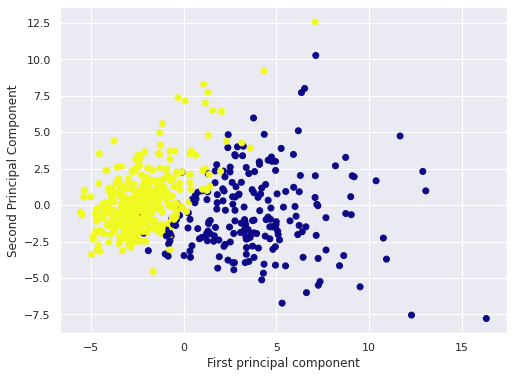

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=cancer['target'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [ ]:
print(pca.components_[0].shape)
pca.components_[0]

(30,)


array([0.21890244, 0.10372458, 0.22753729, 0.22099499, 0.14258969,
       0.23928535, 0.25840048, 0.26085376, 0.13816696, 0.06436335,
       0.20597878, 0.01742803, 0.21132592, 0.20286964, 0.01453145,
       0.17039345, 0.15358979, 0.1834174 , 0.04249842, 0.10256832,
       0.22799663, 0.10446933, 0.23663968, 0.22487053, 0.12795256,
       0.21009588, 0.22876753, 0.25088597, 0.12290456, 0.13178394])

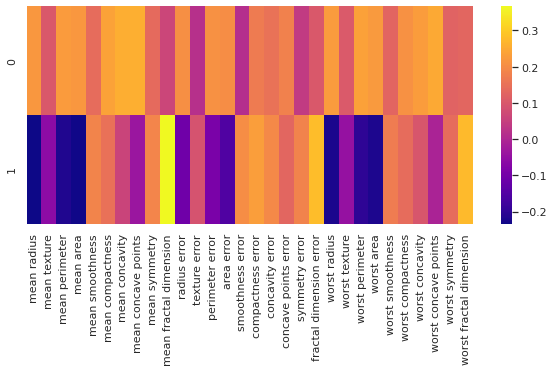

In [ ]:
# higher number, closer to principal components
df_comp = pd.DataFrame(pca.components_, columns=cancer['feature_names'])
sns.heatmap(df_comp, cmap='plasma',)

## 2.2 Kernel PCA

In [3]:
# import data
dataset = pd.read_csv('https://raw.githubusercontent.com/shivang98/Social-Network-ads-Boost/master/Social_Network_Ads.csv')
x = dataset.iloc[:, [2,3]]
y = dataset.iloc[:, 4]

# split data
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.25, random_state=0)

#feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
# Apply kernel PCA and it changes the variables, and non linear variables will become linear
kpca = KernelPCA(n_components = 2, kernel = 'rbf')
X_train = kpca.fit_transform(X_train)
X_test = kpca.transform(X_test)

In [ ]:
# fit
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, Y_train)
# predict
y_pred = classifier.predict(X_test)

In [ ]:
confusion_matrix(Y_test, y_pred)

array([[64,  4],
       [ 6, 26]])

## 2.3 Linear Discriminant analysis

Quite similar to PCA, but interested in separating most of the classes of multiple variables. LDA is supervised because it is related to dependent variable. It tries to maximize the distance between projected means and minimize the sum of the projected scatter


https://www.youtube.com/watch?v=azXCzI57Yfc

https://www.mygreatlearning.com/blog/linear-discriminant-analysis-or-lda/

http://www.adeveloperdiary.com/data-science/machine-learning/linear-discriminant-analysis-from-theory-to-code/

In [8]:
# import data
dataset = pd.read_csv('https://raw.githubusercontent.com/MateLabs/Public-Datasets/master/Datasets/wine.csv')
X = dataset.iloc[:, 0:13]
y = dataset.iloc[:, 13]

# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
# Applying LDA before training model, x left with 2 variables
lda = LinearDiscriminantAnalysis (n_components = 2)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [10]:
# fitting
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
# predict
y_pred = classifier.predict(X_test)

In [11]:
confusion_matrix(y_test, y_pred)

array([[14,  0,  0],
       [ 0,  6,  0],
       [ 0,  0, 16]])

## 2.4 AutoEncoder

https://www.analyticsvidhya.com/blog/2021/06/dimensionality-reduction-using-autoencoders-in-python/

## 2.5 TSNE

Based on Distance --> Joint Probability

Map on Low Dimensional (Randomly) --> T-Graph

https://medium.com/swlh/t-sne-explained-math-and-intuition-94599ab164cf

https://www.youtube.com/watch?v=NEaUSP4YerM

https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a

## 2.6 UMAP
Slight different from TSne. It preserves both local and global strucutre

https://www.youtube.com/watch?v=6BPl81wGGP8


https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668

https://umap-learn.readthedocs.io/en/latest/clustering.html



## 2.7 PACMAP

https://towardsdatascience.com/why-you-should-not-rely-on-t-sne-umap-or-trimap-f8f5dc333e59

https://pypi.org/project/pacmap/

## 2.8 Isomap

https://towardsdatascience.com/isomap-embedding-an-awesome-approach-to-non-linear-dimensionality-reduction-fc7efbca47a0

# 3. Parametric Distribution Fitting

Test the distribution using KS Test

https://www.statology.org/kolmogorov-smirnov-test-python/

In [4]:
dataset = pd.read_csv('https://raw.githubusercontent.com/shivang98/Social-Network-ads-Boost/master/Social_Network_Ads.csv')
dataset.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [5]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)

        # fit and get parameters
        param = dist.fit(data)
        params[dist_name] = param

        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for " + dist_name + " = " + str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: " + str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: " + str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

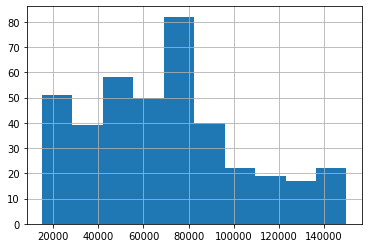

In [6]:
dataset['EstimatedSalary'].hist(bins=10)

In [7]:
best_dist, best_p, best_params = get_best_distribution(dataset['EstimatedSalary'])

p value for norm = 0.04483377017070278
p value for exponweib = 0.00019199863595852613
p value for weibull_max = 9.808412879486938e-305
p value for weibull_min = 8.055396547242545e-262


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for pareto = 1.6716886766036144e-31
p value for genextreme = 2.569000248787886e-201
Best fitting distribution: norm
Best p value: 0.04483377017070278
Parameters for the best fit: (69742.5, 34054.3124104716)


In [ ]:
# check cdf probabilities
st.norm.cdf(100000, 69742.5, 34054.3124104716)

0.8128659937347658

# 4. Non-Parametric Fitting

In [ ]:
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity

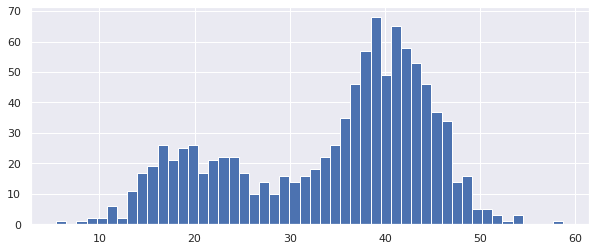

In [ ]:
sample1 = normal(loc=20, scale=5, size=300)
sample2 = normal(loc=40, scale=5, size=700)
sample = hstack((sample1, sample2))
plt.hist(sample, bins=50)
plt.show()

In [ ]:
# fit density
model = KernelDensity(bandwidth=2, kernel='gaussian')
sample = sample.reshape((len(sample), 1))
model.fit(sample)

KernelDensity(algorithm='auto', atol=0, bandwidth=2, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

In [ ]:
values = asarray([value for value in range(1, 60)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = exp(probabilities)